<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Shifted/BaseCASE_Shifted_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 50.0 MB/s eta 0:00:00


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from sklearn.neighbors import BallTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# --- Load NetCDF and CSV Files ---
nc_file_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_PM25_rh50.csv"

nc_data = xr.open_dataset(nc_file_path)
station_data = pd.read_csv(csv_file_path)

# --- Extract NetCDF Grid Coordinates (Edges) ---
lon_edges = nc_data["lon"].values  # Grid edges in lon
lat_edges = nc_data["lat"].values  # Grid edges in lat
pm25_values_2D = nc_data["SURF_ug_PM25_rh50"].values.squeeze()  # PM₂.₅ values at edges

# --- Compute Grid Cell Centers ---
lon_step = (lon_edges[-1] - lon_edges[0]) / (len(lon_edges) - 1)
lat_step = (lat_edges[-1] - lat_edges[0]) / (len(lat_edges) - 1)

lon_centers = lon_edges[:-1] + (lon_step / 2)  # Compute center of each grid cell
lat_centers = lat_edges[:-1] + (lat_step / 2)

# --- Create Grid Center Points ---
lon_grid, lat_grid = np.meshgrid(lon_centers, lat_centers)
grid_points_centered = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# --- Extract Station Coordinates ---
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_coords = np.column_stack((station_lons, station_lats))

# --- Nearest Grid Cell Assignment Using Haversine Distance (`BallTree`) ---
station_tree = BallTree(np.radians(station_coords), metric="haversine")
_, nearest_station_indices = station_tree.query(np.radians(grid_points_centered), k=1)
nearest_stations = station_coords[nearest_station_indices[:, 0]]

# --- Define Function for Haversine Distance Calculation ---
def haversine_distance(lon1, lat1, lon2, lat2):
    """Computes Haversine distance (in km) between two points (lat/lon in degrees)."""
    R = 6371  # Earth radius in km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# --- Apply IDW to Compute PM₂.₅ at Grid Centers ---
beta = 2  # Distance exponent
epsilon = 1e-6  # Small constant to avoid division errors

pm25_centered = np.zeros((len(lat_centers), len(lon_centers)))

for i in range(len(lat_centers)):
    for j in range(len(lon_centers)):
        lon_c, lat_c = lon_centers[j], lat_centers[i]  # Current grid cell center

        # Identify four surrounding edges
        if j < len(lon_edges) - 1 and i < len(lat_edges) - 1:
            corners = np.array([
                [lon_edges[j], lat_edges[i]],     # Top-left (TL)
                [lon_edges[j+1], lat_edges[i]],   # Top-right (TR)
                [lon_edges[j], lat_edges[i+1]],   # Bottom-left (BL)
                [lon_edges[j+1], lat_edges[i+1]]  # Bottom-right (BR)
            ])

            values = np.array([
                pm25_values_2D[i, j],    # PM₂.₅ at TL
                pm25_values_2D[i, j+1],  # PM₂.₅ at TR
                pm25_values_2D[i+1, j],  # PM₂.₅ at BL
                pm25_values_2D[i+1, j+1] # PM₂.₅ at BR
            ])

            # Compute distances from the grid center to the four surrounding edges
            dists_to_center = np.array([
                haversine_distance(lon_c, lat_c, corners[k, 0], corners[k, 1]) for k in range(4)
            ])

            # Compute IDW weights
            weights = 1 / ((dists_to_center + epsilon) ** beta)
            weights /= np.sum(weights)  # Normalize weights

            # Compute interpolated PM₂.₅ value
            pm25_centered[i, j] = np.sum(weights * values)

# --- Compute Nearest Modeled PM₂.₅ Values for Stations ---
pm25_centered_1D = pm25_centered.ravel()
tree_centered = cKDTree(grid_points_centered)
_, indices = tree_centered.query(station_coords)

nearest_pm25 = pm25_centered_1D[indices]
observed_PM25 = station_data["SURF_ug_PM25_rh50"].values

# --- Compute Bias and Errors ---
bias = observed_PM25 - nearest_pm25
mae = mean_absolute_error(observed_PM25, nearest_pm25)
rmse = np.sqrt(mean_squared_error(observed_PM25, nearest_pm25))

print(f"\nComputed Bias and Errors:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# --- Save the Corrected CSV File ---
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "nearest_grid_lon": grid_points_centered[indices, 0],  # Nearest grid cell center
    "nearest_grid_lat": grid_points_centered[indices, 1],
    "SURF_ug_PM25_rh50": observed_PM25,  # Observed PM₂.₅
    "nearest_SURF_ug_PM25_rh50": nearest_pm25,  # Modeled PM₂.₅ (IDW interpolated)
    "bias": bias  # Bias (Observed - Modeled)
})

df_matched.to_csv("matched_PM25_optimized.csv", index=False)
print("\n Corrected file saved: matched_PM25_optimized.csv")



Computed Bias and Errors:
Mean Absolute Error (MAE): 1.2980
Root Mean Squared Error (RMSE): 3.2656

 Corrected file saved: matched_PM25_optimized.csv


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


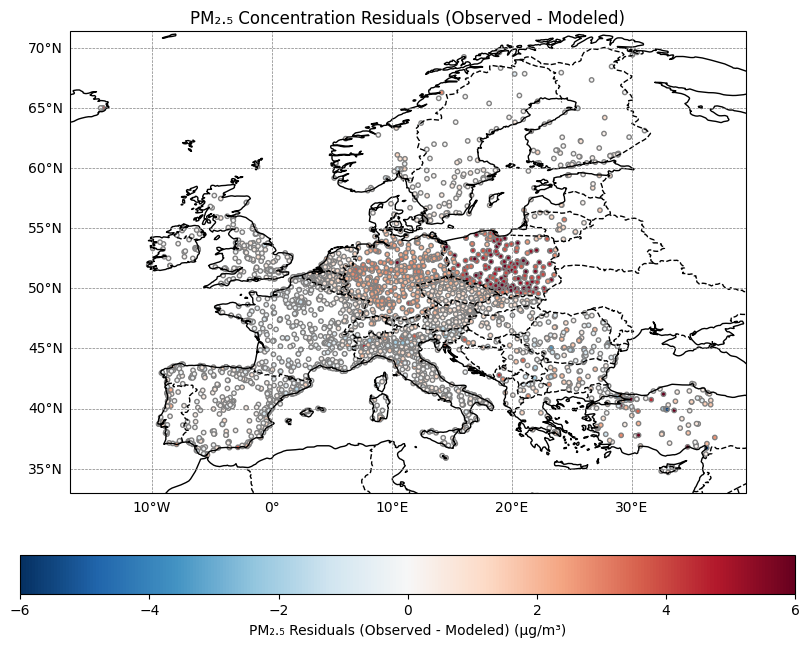

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_PM25_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= "grey",
    s=10,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

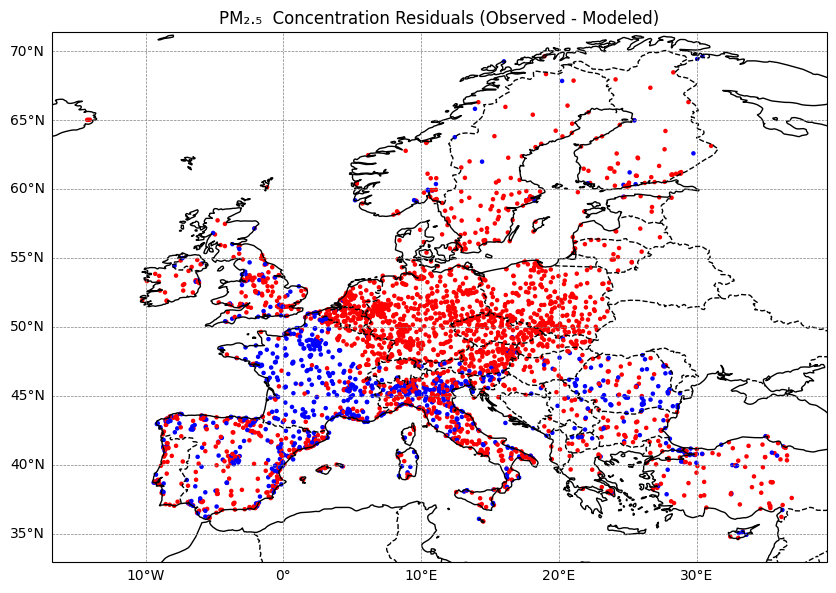

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_PM25_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["PM25_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)


# Τίτλος
ax.set_title("PM₂.₅  Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

